In [1]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import datasets, transforms 

In [2]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(DEVICE, torch.cuda.get_device_name(), print(f'torch : {torch.__version__}'))

torch : 1.12.1+cu113
cuda NVIDIA GeForce GTX 1650 None


In [3]:
EPOCHS = 10
BATCH_SIZE = 128

In [4]:
train_datatset = datasets.CIFAR10(root = '../../data/cifar10',
                                  train=True,
                                  download=True,
                                  transform= transforms.Compose([
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5),
                                                           (0.5,0.5,0.5))
                                  ]))
test_datatset = datasets.CIFAR10(root = '../../data/cifar10',
                                  train=False,
                                  download=True,
                                  transform= transforms.Compose([
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5),
                                                           (0.5,0.5,0.5))
                                  ]))
train_loader = torch.utils.data.DataLoader(train_datatset,
                                            shuffle =  True,
                                            batch_size = BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_datatset,
                                            shuffle =  False,
                                            batch_size = BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
for (X_train, y_train) in train_loader :
    print(X_train.size(), y_train.size())
    print(X_train.type(), y_train.type())
    break

torch.Size([128, 3, 32, 32]) torch.Size([128])
torch.FloatTensor torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

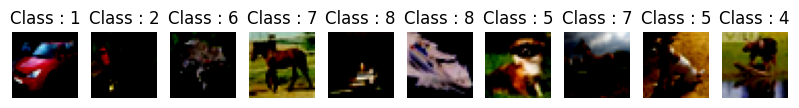

In [6]:
pltsize = 1
plt.figure(figsize = (pltsize * 10, pltsize))
for i in range(10) :
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title(f'Class : {y_train[i].item()}')
plt.show()

In [7]:
class BasicBlock(nn.Module) :
    def __init__(self, in_planes, planes, stride = 1) :
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size= 3,
                               stride= stride,
                               padding = 1,
                               bias = False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size= 3,
                               stride = 1,
                               padding = 1,
                               bias = False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()

        if in_planes != planes or stride != 1 :
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size= 1,
                          stride = stride,
                          bias = False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x) :
        out = self.bn1(self.conv1(x))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out 
    
class ResNet(nn.Module) :
    def __init__(self, num_classes = 10) :
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, 
                               kernel_size= 3,
                               stride = 1,
                               padding = 1,
                               bias = False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self._make_layer(16, 4, 1)
        self.layer2 = self._make_layer(32, 4, 2)
        self.layer3 = self._make_layer(64, 4, 2)

        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, blocks, stride) :
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides :
            layers.append(BasicBlock(self.in_planes, planes, stride = stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x) :
        out = self.bn1(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out 



In [8]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss() 
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [9]:
def train(model, train_loader, optimizer, log_intervals = 50) :
    model.train() 

    for batch_idx, (image, label) in enumerate(train_loader) :
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)

        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_intervals == 0 :
            print('Train_EPOCH : {} [{} / {}]({:.0f}%), Train_loss : {:.6f}'.format(
                Epoch, batch_idx * len(image), len(train_loader.dataset),
                batch_idx * 100 / len(train_loader), loss.item()
            ))

In [10]:
def evaluate(model, test_loader) :
    model.eval() 
    correct = 0
    test_loss = 0

    with torch.no_grad() :
        for image, label in test_loader : 
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item() 
            test_loss = criterion(output, label) 

        test_loss /= len(test_loader.dataset)
        test_accuracy = correct * 100/ len(test_loader.dataset)

        return test_loss, test_accuracy

In [11]:
es = 0 
best_accuracy = 0

for Epoch in range(1, EPOCHS + 1) :
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\nEPOCH : {}, Test_loss : {:.6f}, Test_accuracy : {:.2f}%\n'.format(
        Epoch, test_loss, test_accuracy
    ))

    if test_accuracy > best_accuracy :
        best_accuracy = test_accuracy
        es = 0
        best_model = model
    else :
        es += 1 

    if es >= 10 :
        print(best_accuracy)
        break

Train_EPOCH : 1 [0 / 50000](0%), Train_loss : 2.403355
Train_EPOCH : 1 [6400 / 50000](13%), Train_loss : 1.908258
Train_EPOCH : 1 [12800 / 50000](26%), Train_loss : 1.682219
Train_EPOCH : 1 [19200 / 50000](38%), Train_loss : 1.606184
Train_EPOCH : 1 [25600 / 50000](51%), Train_loss : 1.619668
Train_EPOCH : 1 [32000 / 50000](64%), Train_loss : 1.516638
Train_EPOCH : 1 [38400 / 50000](77%), Train_loss : 1.503708
Train_EPOCH : 1 [44800 / 50000](90%), Train_loss : 1.459022

EPOCH : 1, Test_loss : 0.000125, Test_accuracy : 44.42%

Train_EPOCH : 2 [0 / 50000](0%), Train_loss : 1.367836
Train_EPOCH : 2 [6400 / 50000](13%), Train_loss : 1.269243
Train_EPOCH : 2 [12800 / 50000](26%), Train_loss : 1.226064
Train_EPOCH : 2 [19200 / 50000](38%), Train_loss : 1.232836
Train_EPOCH : 2 [25600 / 50000](51%), Train_loss : 1.255791
Train_EPOCH : 2 [32000 / 50000](64%), Train_loss : 1.182604
Train_EPOCH : 2 [38400 / 50000](77%), Train_loss : 1.081711
Train_EPOCH : 2 [44800 / 50000](90%), Train_loss : 1.2